In [1]:
import ee
import geemap

In [2]:
geemap.ee_initialize()


In [5]:
Map=geemap.Map()

In [6]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [7]:
# After drawing the bounding box on the map, run the following lines to get the coordinates of the bounding box
roi = Map.user_roi

if roi is None:
    print('No region of interest selected')
else:
    coordinates = roi.getInfo()['coordinates']

    # Load the JAXA ALOS DSM data
    alos_dsm_collection = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2")

    # Mosaic the collection and clip to the ROI
    alos_dsm = alos_dsm_collection.mosaic().clip(ee.Geometry.Polygon(coordinates))

    # Select the DSM band
    dsm_band = alos_dsm.select('DSM')

    # Define visualization parameters
    vis_params = {
        'min': 0,
        'max': 3000,
        'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
    }

    # Add the DSM band to the map object
    Map.addLayer(dsm_band, vis_params, 'JAXA ALOS DSM')

    # Set the map object to center on the ROI
    Map.centerObject(ee.Geometry.Polygon(coordinates), 17)

    # Display the map
    Map


In [8]:
Map

Map(bottom=12731315.0, center=[39.76943412033348, 127.51463600000002], controls=(WidgetControl(options=['posit…

In [9]:
# Define the path and name for the downloaded file
out_file_path = "hamheung_dsm.tif"

# Use geemap to export the DSM band as a GeoTIFF
geemap.ee_export_image(dsm_band, filename=out_file_path, scale=10, region=roi, file_per_band=False)


Generating URL ...
An error occurred while downloading.
Total request size (499011588 bytes) must be less than or equal to 50331648 bytes.


In [11]:
print(roi_bounds.getInfo())


{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[126.641448, 39.382649], [128.387824, 39.382649], [128.387824, 40.151106], [126.641448, 40.151106], [126.641448, 39.382649]]]}


In [14]:
# import geemap
# import ee

# Assume dsm_band and roi are already defined

# Define the path and name for the downloaded files
out_file_path = "dem_tiles/hamheung_dsm_tile_{x}_{y}.tif"

# Define the number of tiles in x and y direction
num_tiles_x = 5
num_tiles_y = 5

# Get the bounds of the roi
roi_bounds = roi.bounds()
# xmin, ymin, xmax, ymax = roi_bounds.getInfo()['coordinates'][0]

# Extract the coordinates of the bounding box
coordinates = roi_bounds.getInfo()['coordinates'][0]

# Unpack the coordinates
xmin, ymin = coordinates[0]
xmax, ymax = coordinates[2]


# Calculate the size of each tile
tile_width = (xmax - xmin) / num_tiles_x
tile_height = (ymax - ymin) / num_tiles_y

# Loop through each tile
for x in range(num_tiles_x):
    for y in range(num_tiles_y):
        # Define the roi for this tile
        tile_roi = ee.Geometry.Rectangle(
            [xmin + x * tile_width, ymin + y * tile_height,
             xmin + (x + 1) * tile_width, ymin + (y + 1) * tile_height]
        )
        
        # Define the output file path for this tile
        tile_out_file_path = out_file_path.format(x=x, y=y)
        
        # Export this tile
        geemap.ee_export_image(dsm_band, filename=tile_out_file_path, scale=10, region=tile_roi, file_per_band=False)


Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_0_0.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_0_1.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_0_2.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_0_3.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_0_4.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_1_0.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/hamheung_dsm_tile_1_1.tif
Generating URL ...
Please wait ...
Data downloaded to /

In [6]:
!pip install pysheds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 9.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1


In [1]:
import glob

# List all the DEM files in the specified directory
dem_files = glob.glob('/Users/gigisung/gigi_git/undatathon/hamheung/dem_tiles/*.tif')


In [2]:
import rasterio
from rasterio.merge import merge

# Read the DEM files
dem_datasets = [rasterio.open(file) for file in dem_files]

# Merge the DEM files
merged_dem, out_transform = merge(dem_datasets)

# Write the merged DEM to a new file
out_meta = dem_datasets[0].meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": merged_dem.shape[1],
                 "width": merged_dem.shape[2],
                 "transform": out_transform})

with rasterio.open('/Users/gigisung/gigi_git/undatathon/hamheung/merged_dem.tif', "w", **out_meta) as dest:
    dest.write(merged_dem)


In [27]:
from pysheds.grid import Grid




grid = Grid.from_raster('/Users/gigisung/gigi_git/undatathon/hamheung/merged_dem.tif')
dem = grid.read_raster('/Users/gigisung/gigi_git/undatathon/hamheung/merged_dem.tif')

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)


In [35]:
acc

Raster([[ 0., 12.,  6., ...,  0.,  0.,  0.],
        [ 0., 12.,  6., ...,  1.,  1., 37.],
        [ 0., 11.,  3., ...,  2., 36.,  0.],
        ...,
        [ 2.,  2.,  6., ...,  1.,  2.,  2.],
        [ 0.,  1.,  1., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [50]:
import numpy as np

print('Min:', np.min(acc))
print('Max:', np.max(acc))
print('Mean:', np.mean(acc))
print('Median:', np.median(acc))


Min: 0.0
Max: 1255125.0
Mean: 178.69756218382798
Median: 3.0


In [51]:
for threshold in [10, 100, 200, 500, 1000]:
    hand = grid.compute_hand(fdir, dem, acc > threshold)
    # visualize or analyze the hand result


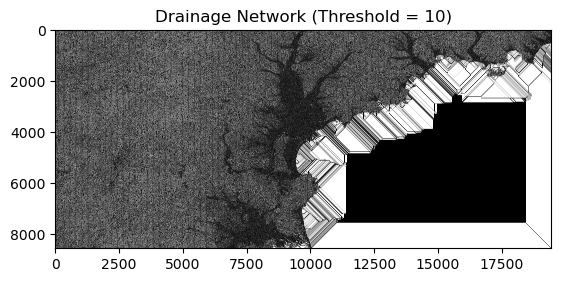

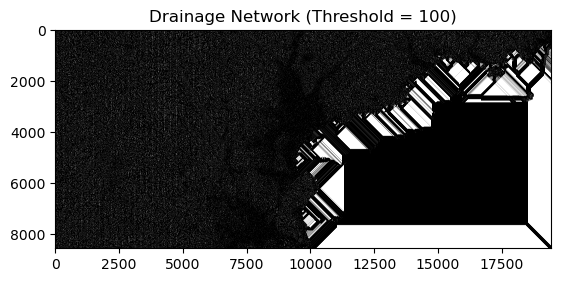

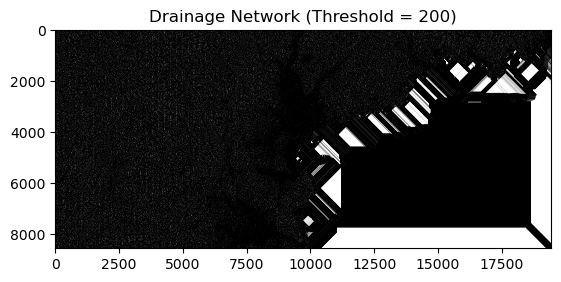

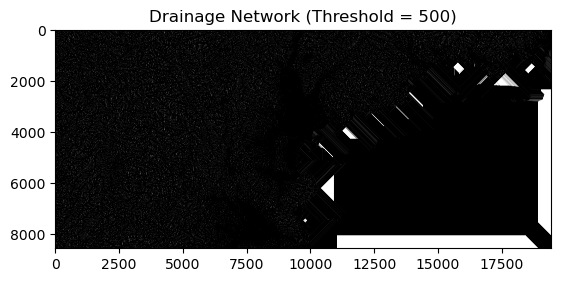

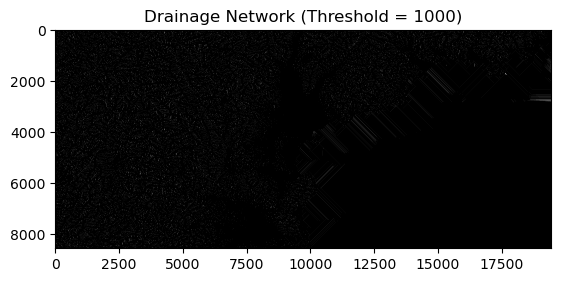

In [52]:
import matplotlib.pyplot as plt

for threshold in [10, 100, 200, 500, 1000]:
    plt.figure()
    plt.imshow(acc > threshold, cmap='gray')
    plt.title(f'Drainage Network (Threshold = {threshold})')
    plt.show()


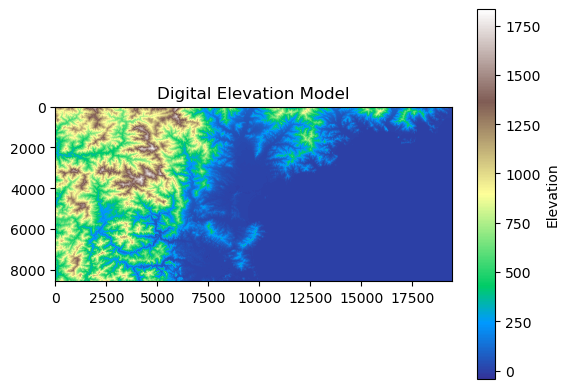

In [53]:
plt.figure()
plt.imshow(dem, cmap='terrain')
plt.colorbar(label='Elevation')
plt.title('Digital Elevation Model')
plt.show()


In [54]:
hand = grid.compute_hand(fdir, dem, acc > 100)


In [55]:
hand

Raster([[nan],
        [nan],
        [nan]])

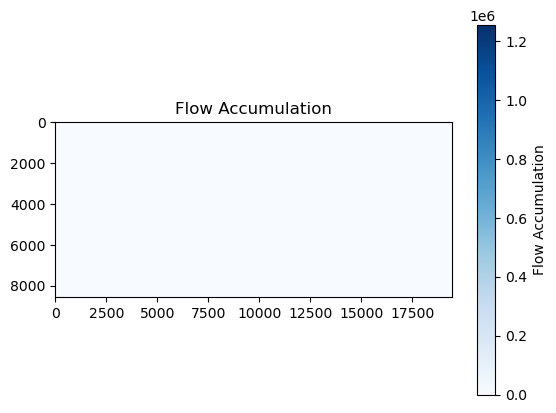

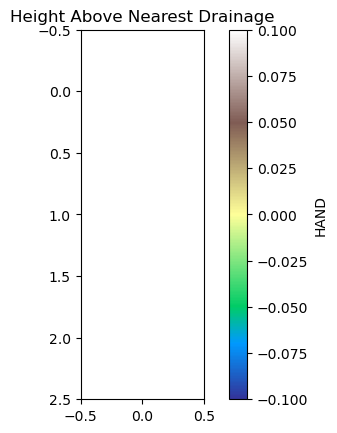

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(acc, cmap='Blues')
plt.colorbar(label='Flow Accumulation')
plt.title('Flow Accumulation')
plt.show()

plt.figure()
plt.imshow(hand, cmap='terrain')
plt.colorbar(label='HAND')
plt.title('Height Above Nearest Drainage')
plt.show()


In [30]:
# Specify outlet
x, y = 127.416986, 39.443480

# Delineate a catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')

# Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

In [31]:
hand_view

Raster([[1.],
        [1.],
        [1.]])

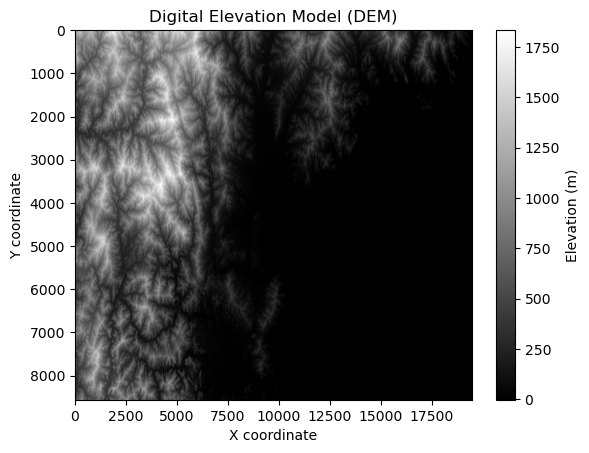

In [24]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure()



# Display the data
plt.imshow(inflated_dem, cmap='gray', aspect='auto')

# Add a colorbar to show the color scale
plt.colorbar(label='Elevation (m)')

# Optionally, set labels for the axes
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Optionally, set a title
plt.title('Digital Elevation Model (DEM)')

# Show the plot
plt.show()

In [25]:
import numpy as np
# from pysheds.grid import Grid

# Instantiate grid from raster
# grid = Grid.from_raster('./data/dem.tif')
# dem = grid.read_raster('./data/dem.tif')

# Resolve flats and compute flow directions
# inflated_dem = grid.resolve_flats(dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

In [26]:
fdir

Raster([[0, 0],
        [0, 0]])

In [13]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

In [15]:
# Specify outlet
x, y = 127.416986, 39.443480

# Delineate a catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')

# Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

In [18]:
hand_view

Raster([[ 0., nan],
        [nan,  0.]])

### Estimating inundation extent (constant channel depth)



In [16]:
inundation_extent = np.where(hand_view < 3, 3 - hand_view, np.nan)


In [17]:
inundation_extent


array([[ 3., nan],
       [nan,  3.]])